# Distress Detection from Speech Data

Distress is defined as feeling of anxiety, fear and pain. Whenever a human being is in distress, it is reflected in their voice. Distress detection has many real life applications for elderly, people under protection, people living in dangerous areas, people travelling alone at night, etc. In this project, we are trying to detect distress from speech data using an artificial neural network.

In [10]:
import os
import librosa
import tensorflow as tf
from librosa.display import specshow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras import Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D

%matplotlib inline
sns.set()

### Dataset: CREMA-D
CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified).  
Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).
#### Filename labeling conventions
The Actor id is a 4 digit number at the start of the file. Each subsequent identifier is separated by an underscore (_).  

Actors spoke from a selection of 12 sentences (in parentheses is the three letter acronym used in the second part of the filename):
* It's eleven o'clock (IEO).
* That is exactly what happened (TIE).
* I'm on my way to the meeting (IOM).
* I wonder what this is about (IWW).
* The airplane is almost full (TAI).
* Maybe tomorrow it will be cold (MTI).
* I would like a new alarm clock (IWL)
* I think I have a doctor's appointment (ITH).
* Don't forget a jacket (DFA).
* I think I've seen this before (ITS).
* The surface is slick (TSI).
* We'll stop in a couple of minutes (WSI).

The sentences were presented using different emotion (in parentheses is the three letter code used in the third part of the filename):

* Anger (ANG)
* Disgust (DIS)
* Fear (FEA)
* Happy/Joy (HAP)
* Neutral (NEU)
* Sad (SAD)

and emotion level (in parentheses is the two letter code used in the fourth part of the filename):

* Low (LO)
* Medium (MD)
* High (HI)
* Unspecified (XX)

In [11]:
# Loading the name of audio files
audio_files = os.listdir(r'AudioWAV')
audio_files = ['AudioWAV/'+file for file in audio_files]
label = [0] * len(audio_files)

In [12]:
# Assigning a class label to each audio file
for i in range(len(audio_files)):
    name = audio_files[i].split('_')
    if 'ANG' in name:
        label[i] = 1
    elif 'FEA' in name:
        label[i] = 2

In [13]:
#Lets find the sample rate of wav files
sample_rate = []
for i in (audio_files):
    _,sr = librosa.load(i)
    sample_rate.append(sr)
print(np.unique(np.asarray(sample_rate)))

[22050]


In [14]:
#GLOBAL VARIABLES
SR = 22050
MAXLEN = 22050*4
N_FFT = 1024
HOP_LENGTH = 512
N_MFCC = 20

In [15]:
# Loading the wav files
data = [librosa.load(file, sr = 22050)[0] for file in audio_files]

### Audio Length

In [16]:
# Finding the minimum and maximum duration of files in dataset
duration = [round(len(aud)/SR, 0) for aud in data]
print('Min Duration:' +str(min(duration))+' sec')
print('Max Duration:' +str(max(duration))+' sec')

Min Duration:1.0 sec
Max Duration:5.0 sec


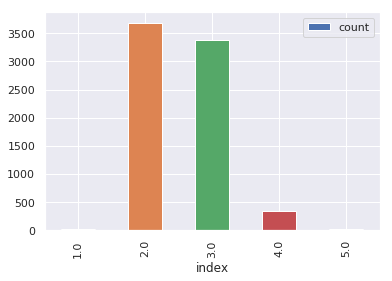

In [17]:
# Histogram of audio lengths
audio_length = pd.Series(duration).value_counts().reset_index()
audio_length.columns = ['index', 'count']
audio_length.sort_values(by = 'index', inplace=True)
audio_length.plot(kind = 'bar', x = 'index', y = 'count')

As we can see from the graph of length of audio files, most of the files are 2-4 second long. Hence, we have decided to convert all audio clips to 4 second long. We do this by padding shorter clips or by clipping files with longer duration.

In [18]:
# Padding
data = pad_sequences(data, maxlen=MAXLEN, dtype = 'float32')

In [19]:
type(data[0])

numpy.ndarray

In [20]:
data_length = []

for i in (data):
    data_length.append(i.shape)
print(np.unique(np.asarray(data_length)))

[88200]


In [21]:
np.save('data', data)
np.save('label', label)

### Listening to Audio Files
#### ANGER
<audio src="AudioWAV/1001_DFA_ANG_XX.wav" controls>Audio file not availablle</audio>
#### FEAR
<audio src="AudioWAV/1001_DFA_FEA_XX.wav" controls>Audio file not availablle</audio>
#### OTHER
##### DISGUST
<audio src="AudioWAV/1001_DFA_DIS_XX.wav" controls>Audio file not availablle</audio>
##### HAPPY
<audio src="AudioWAV/1001_DFA_HAP_XX.wav" controls>Audio file not availablle</audio>
##### NEUTRAL
<audio src="AudioWAV/1001_DFA_NEU_XX.wav" controls>Audio file not availablle</audio>
##### SAD
<audio src="AudioWAV/1001_DFA_SAD_XX.wav" controls>Audio file not availablle</audio>

### Data Distribution

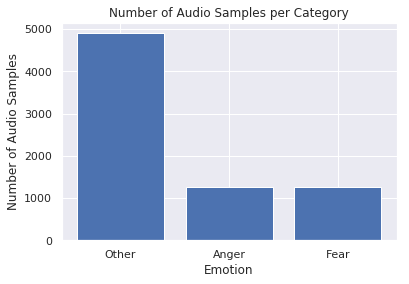

In [22]:
values, count = np.unique(label, return_counts=True)
plt.figsize = (16,10)
plt.bar(values, count)
plt.xlabel('Emotion')
plt.title('Number of Audio Samples per Category')
plt.ylabel('Number of Audio Samples')
plt.xticks([0, 1, 2], ['Other', 'Anger', 'Fear'])
plt.show()

## Feature Extraction

We are extracting three features for our classification:

1. **MFCC:** Sounds generated by a human are filtered by the shape of the vocal tract. The shape of the vocal tract manifests itself in the envelope of the short time power spectrum, and the job of MFCCs is to accurately represent this envelope.

2. **MFCC Delta:** Local estimate of the derivative of the input data along the Time axis

3. **MFCC Delta Delta:** Local estimate of the second order derivative of the input data along the Time axis

Other features like Chroma, Tonnetz , zero crossing rates were tried but didn't improve the results. These features are more related to musical notes.

In [23]:
#Extract Features of each sample 
def extract_feature(data,featured_data):
    
    for i in range(len(data)):
        
        mfcc = librosa.feature.mfcc(y=data[i] ,sr=SR,n_mfcc=N_MFCC)
        mfcc_delta = librosa.feature.delta(mfcc,mode='nearest')
        mfcc_delta_delta = librosa.feature.delta(mfcc,mode='nearest',order=2)
        features = np.vstack((np.vstack((mfcc,mfcc_delta)),mfcc_delta_delta))
        featured_data.append(features.T)
        
def extract_melspectrogram(data,mel_data):
    for i in range(len(data)):
        ms = librosa.feature.melspectrogram(y=data[i], sr=SR)
        mel_data.append(ms)
    
    

In [24]:
# Loading the audio files
with open('data.npy', 'rb') as file:
    data = np.load(file)
featured_data = []
mel_data = []
extract_feature(data,featured_data)
extract_melspectrogram(data,mel_data)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/signal/_savitzky_golay.py:135: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  coeffs, _, _, _ = lstsq(A, y)


In [25]:
featured_data = np.asarray(featured_data)
featured_data.shape

(7442, 173, 60)

In [26]:
mel_data= np.asarray(mel_data)
mel_data.shape

(7442, 128, 173)

In [27]:
label = np.asarray(label)
label.shape

(7442,)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(featured_data,label, test_size=0.20, random_state=42)

In [29]:
print(f'train:{X_train.shape}, test{X_test.shape} , y_train:{y_train.shape}, y_test:{y_test.shape}')

train:(5953, 173, 60), test(1489, 173, 60) , y_train:(5953,), y_test:(1489,)


In [30]:
# Reshape for CNN input
X_train = np.array([x.reshape( (173, 60, 1) ) for x in X_train])
X_test = np.array([x.reshape( (173, 60, 1) ) for x in X_test])

In [31]:
X_test.shape

(1489, 173, 60, 1)

### Build Convolutional Layer

In [32]:
model = tf.keras.Sequential()
input_shape=(173,60, 1)

model.add(Conv2D(24, (2, 2), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (2, 2), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (2, 2), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(3))
model.add(Activation('softmax'))
      

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [33]:
tf.__version__

'1.13.1'

### Train Convolutional Neural Network

In [34]:
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])

model.fit(
    x=X_train, 
    y=y_train,
    epochs=10,
    batch_size=173,
    validation_data= (X_test, y_test))

score = model.evaluate(
    x=X_test,
    y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 5953 samples, validate on 1489 samples
Epoch 1/10
5953/5953 [==============================] - 18s 3ms/sample - loss: 1.7792 - acc: 0.6083 - val_loss: 0.7397 - val_acc: 0.6998
Epoch 2/10
5953/5953 [==============================] - 19s 3ms/sample - loss: 0.7814 - acc: 0.6960 - val_loss: 0.7054 - val_acc: 0.7032
Epoch 3/10
5953/5953 [==============================] - 20s 3ms/sample - loss: 0.7375 - acc: 0.7097 - val_loss: 0.6956 - val_acc: 0.7146
Epoch 4/10
5953/5953 [==============================] - 18s 3ms/sample - loss: 0.7203 - acc: 0.7124 - val_loss: 0.6670 - val_acc: 0.7220
Epoch 5/10
5953/5953 [==============================] - 19s 3ms/sample - loss: 0.7105 - acc: 0.7190 - val_loss: 0.6509 - val_acc: 0.7361
Epoch 6/10
5953/5953 [==============================] - 19s 3ms/sample - loss: 0.6897 - acc: 0.7201 - val_loss: 0.6407 - val_acc: 0.7320
Epoch 7/10
5953/5953 [==============================] - 18s 3ms/sample - loss: 0.6718 - acc: 0.7287 - val_loss: 0.6320 - val_acc: 

In [35]:
score

[0.621827249362054, 0.740094]

In [38]:
!pwd

/Users/saurabhiu/Desktop/DeepLearningProject/CREMA-D
